In [1]:
### **Test 3: IRIS Dataset** 

#This test applies the VAT algorithm to the well-known IRIS dataset.  
#The dataset contains 150 samples with four features, representing different species of flowers.  
#We visualize the original and ordered dissimilarity matrices to assess clustering tendencies.  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import shortest_path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, load_iris
from matplotlib.colors import LinearSegmentedColormap
import warnings

class VAT:
    
    def __init__(self, normalize=True, colormap='gray_r', n_samples_max=5000):
        self.normalize = normalize
        self.n_samples_max = n_samples_max
        self.cmap = plt.cm.gray_r if colormap == 'gray_r' else LinearSegmentedColormap.from_list('vat_cmap', ['black', 'white'], N=256)
    
    def fit(self, data):
        if isinstance(data, pd.DataFrame):
            data = self.preprocess_data(data)   
        if len(data) > self.n_samples_max:
            data = data[np.random.choice(len(data), self.n_samples_max, replace=False)] 
        self.original_data = data.copy()    
        if data.shape[1] > 2 and self.is_nonlinear(data):
            self.R_ = self.geodesic_distance(data)
        else:
            self.R_ = squareform(pdist(data, 'euclidean'))   
        if self.normalize:
            self.R_ = (self.R_ - self.R_.min()) / (self.R_.max() - self.R_.min()) 
        
        self.order_ = self.vat_ordering(self.R_)
        self.R_ordered_ = self.R_[np.ix_(self.order_, self.order_)]
        return self
    
    def preprocess_data(self, data):
        num_cols = data.select_dtypes(include=[np.number]).columns
        cat_cols = data.select_dtypes(exclude=[np.number]).columns
        
        data[num_cols] = SimpleImputer(strategy='mean').fit_transform(data[num_cols])
        data[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data[cat_cols])   
      
        if len(cat_cols) > 0:
            encoder = OneHotEncoder(drop='first', sparse_output=False)
            encoded = encoder.fit_transform(data[cat_cols])
            return np.hstack((data[num_cols].values, encoded))
        return data[num_cols].values
    
    def is_nonlinear(self, X):
        pca = PCA(n_components=2).fit(X)
        return pca.explained_variance_ratio_[0] < 0.6
    
    def geodesic_distance(self, X):
        n_neighbors = min(15, X.shape[0]-1)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
        distances, indices = nbrs.kneighbors(X) 
        dist_matrix = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j, d in zip(indices[i], distances[i]):
                if i != j:
                    dist_matrix[i,j] = d
                    dist_matrix[j,i] = d
        dist_matrix[dist_matrix == 0] = np.inf
        np.fill_diagonal(dist_matrix, 0)
        return shortest_path(dist_matrix, directed=False)
    
    def vat_ordering(self, R):
        n = R.shape[0]
        P = np.zeros(n, dtype=int)
        J = set(range(n))  
        max_idx = np.unravel_index(np.argmax(R), R.shape)
        P[0] = max_idx[0]
        I = {P[0]}
        J.remove(P[0])      
        for r in range(1, n):
            submatrix = R[np.array(list(I))[:, None], np.array(list(J))]
            min_val = np.min(submatrix)
            min_mask = submatrix == min_val       
            candidates = np.argwhere(min_mask)
            if len(candidates) == 0:
                j_in_J = list(J)[0]
                P[r] = j_in_J
                I.add(j_in_J)
                J.remove(j_in_J)
                continue              
            selected = candidates[np.argmax(candidates[:, 0])]
            i_in_I = list(I)[selected[0]]
            j_in_J = list(J)[selected[1]]
            
            P[r] = j_in_J
            I.add(j_in_J)
            J.remove(j_in_J)      
        return P
    
    def plot_paper_style(self, title=None, figsize=(10, 5)):
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)  
       
        img1 = ax1.imshow(self.R_, cmap=self.cmap, aspect='equal',
                         vmin=0, vmax=1 if self.normalize else None)
        ax1.set_title('Random Dissimilarity Matrix', pad=15)
        ax1.axis('off')
        plt.colorbar(img1, ax=ax1, shrink=0.7)  
       
        img2 = ax2.imshow(self.R_ordered_, cmap=self.cmap, aspect='equal',
                         vmin=0, vmax=1 if self.normalize else None)
        ax2.set_title('Ordered Dissimilarity Matrix', pad=15)
        ax2.axis('off')
        plt.colorbar(img2, ax=ax2, shrink=0.7)  
        if title:
            fig.suptitle(title, y=1.02)   
        plt.tight_layout()
        return fig




Testing IRIS Dataset...


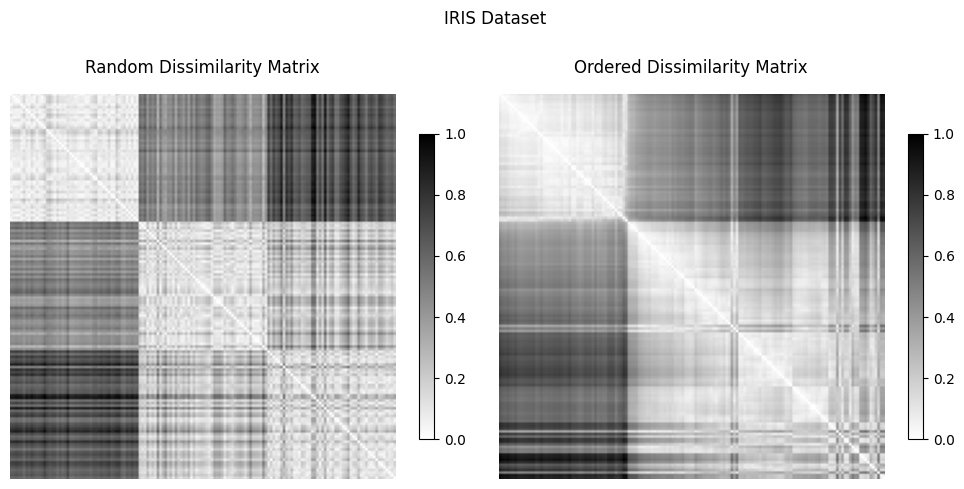

In [3]:

print("\nTesting IRIS Dataset...")
iris = load_iris()
X_iris = iris.data
vat = VAT()
vat.fit(X_iris)
fig = vat.plot_paper_style("IRIS Dataset")
# plt.savefig('vat_paper_iris.png', bbox_inches='tight', dpi=300)
plt.show()